<a href="https://colab.research.google.com/github/zhaoyingpan/592final_project_2021fall/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import dlib
import cv2
import os
import numpy as np
import torchvision.transforms as transforms
import PIL
import scipy.ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Alignment

In [ ]:
def download_landmark_model():
    # save_path = os.path.join("/content", "pretrained_models")
    # if not os.path.exists(save_path):
    #     os.mkdir(save_path)

    landmark_model_path = "/content/shape_predictor_68_face_landmarks.dat"
    if not os.path.exists(landmark_model_path):
        # os.mkdir(model_path)
    
        os.chdir('/content')
        print('Downloading facial landmark detector model...')
        os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
        os.system('bzip2 -d shape_predictor_68_face_landmarks.dat.bz2')
        print('Done.')

    else:
        print('Facial landmark model already exists!')

In [ ]:
download_landmark_model()

Done.


In [ ]:
def draw_face_point(img, single_facial_landmark, is_point=True):
    assert(single_facial_landmark.num_parts == 68)
    if is_point==False:
        draw_on_img(img, single_facial_landmark, 0, 16, is_point, False)
        draw_on_img(img, single_facial_landmark, 17, 21, is_point, False)
        draw_on_img(img, single_facial_landmark, 22, 26, is_point, False)
        draw_on_img(img, single_facial_landmark, 27, 30, is_point, False)
        draw_on_img(img, single_facial_landmark, 30, 35, is_point, True)
        draw_on_img(img, single_facial_landmark, 36, 41, is_point, True)
        draw_on_img(img, single_facial_landmark, 42, 47, is_point, True)
        draw_on_img(img, single_facial_landmark, 48, 59, is_point, True)
        draw_on_img(img, single_facial_landmark, 60, 67, is_point, True)
    else:
        draw_on_img(img, single_facial_landmark, 0, 67, is_point, False)


def draw_on_img(img, single_facial_landmark, start_point, end_point, is_point=True, is_closed=False):

    if is_point==False:
        all_points = []
        for i in range(start_point, end_point+1):
            single_point = [single_facial_landmark.part(i).x, single_facial_landmark.part(i).y]
            all_points.append(single_point)
        all_points = np.array(all_points)
        cv2.polylines(img, [all_points], is_closed, color=(0,255,0), thickness=2)
    else:
        for i in range(start_point, end_point+1):
            single_point = (single_facial_landmark.part(i).x, single_facial_landmark.part(i).y)
            cv2.circle(img, single_point, radius=0, color=(0,255,0), thickness=2)

In [ ]:
def save_facial_landmarks(facial_landmarks, filename):
    with open(filename,'w') as f:
        for p in facial_landmarks.parts():
            f.write("%s %s\n" %(int(p.x),int(p.y)))
    f.close()
def detect_facial_landmarks(model_path, img, count=1, zero_fill=1, if_img=False, if_txt=False, output_path=None):
    face_detector = dlib.get_frontal_face_detector()
    landmark_detector = dlib.shape_predictor(model_path)
    # image_complete_path = image_path + '/' + image_name

    # img = cv2.imread(image_complete_path)
    # img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    face = face_detector(img, 0)
    # facial_landmarks = []
    # for i in range(len(all_faces)):
    face_box = dlib.rectangle(int(face[0].left()), int(face[0].top()), int(face[0].right()), int(face[0].bottom()))
    facial_landmarks = landmark_detector(img, face_box)
    # facial_landmarks.append(single_facial_landmark)

    # facial_landmarks_txt_name = output_path + '/' + image_name[:-4] + '.txt'
    if if_txt:
      facial_landmarks_txt_name = output_path + '/' + str(count).zfill(zero_fill) + '.txt'
      save_facial_landmarks(facial_landmarks, facial_landmarks_txt_name)

    if if_img:
      draw_face_point(img,facial_landmarks)
      cv2.imwrite('/content/test.jpg',img)

    ldm = []
    for p in facial_landmarks.parts():
      ldm.append(p.x)
      ldm.append(p.y)
    ldm = np.array(ldm).reshape(-1,2)
    return ldm

In [ ]:
# model_path = '/content/shape_predictor_68_face_landmarks.dat'
# img = cv2.imread('/content/original1.jpg')
# detect_facial_landmarks(model_path, img, count=1, zero_fill=1, if_img=True, if_txt=False, output_path='/content/pic1.jpg')

In [ ]:
import dlib
from PIL import Image
import scipy
def get_landmark(img, predictor):
    """get landmark with dlib
	:return: np.array shape=(68, 2)
	"""
    detector = dlib.get_frontal_face_detector()

    # img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    shape = None
    for k, d in enumerate(dets):
        shape = predictor(img, d)

    if not shape:
        raise Exception("Could not find face in image! Please try another image!")

    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    return lm
def align_face(img, predictor, output_size=256, transform_size=256):
    """
	:param filepath: str
	:return: PIL Image
	"""

    lm = get_landmark(img, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # read image
    # img = PIL.Image.open(filepath)
    img = Image.fromarray(np.uint8(img[:,:,::-1]))
    # img = img[:,:,::-1]
    # img = img[...,::-1]

    enable_padding = True

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
           int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                          1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Save aligned image.
    return img


def run_alignment(img):
    import dlib
    if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
        print('Downloading files for aligning face image...')
        os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
        os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')
        print('Done.')
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(img=img, predictor=predictor)
    return aligned_image 

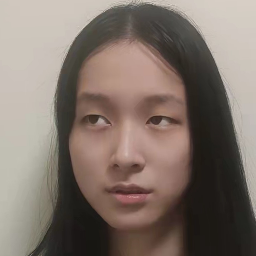

In [ ]:
image = cv2.imread('original1.jpg')
aligned_image = run_alignment(image)
aligned_image

In [ ]:
aligned_image.save('/content/pic1.jpg')

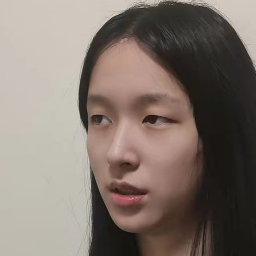

In [ ]:
image = cv2.imread('original2.jpg')
aligned_image = run_alignment(image)
aligned_image

In [ ]:
aligned_image.save('/content/pic2.jpg')

# Video Alignment

In [ ]:
video_path = '/content/original_video.mp4'
video_obj = cv2.VideoCapture(video_path)

success, img = video_obj.read()
frames = []
while success:
  aligned_image = run_alignment(img)
  frames.append(aligned_image)
  
  success, img = video_obj.read()

In [ ]:
def write_video(frames,fps,filename):
  
  fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
  writer = cv2.VideoWriter(filename,fourcc,fps,(256,256))
  for frame in frames:
    writer.write(np.array(frame)[:,:,::-1])

  writer.release()

In [ ]:
filename = '2.mp4'
fps = 35
write_video(frames,fps,filename)

# Extract landmarks for every frame in the video

In [ ]:
import os
os.chdir('/content')
!rm -rf ldm
os.mkdir('ldm')

In [ ]:
def video2ldm(model_path,video_path,output_path):
  video_obj = cv2.VideoCapture(video_path)
  success,image = video_obj.read()
  count = 0
  length = int(video_obj.get(cv2.CAP_PROP_FRAME_COUNT))
  zero_fill = int(pow(length,1/10))+1
  while success:
    aligned_image = run_alignment(image)
    detect_facial_landmarks(model_path, np.array(aligned_image), count, zero_fill, False, True, output_path)
    count += 1   
    success,image = video_obj.read()

In [ ]:
model_path = '/content/shape_predictor_68_face_landmarks.dat'
output_path = '/content/ldm'
video_path = '/content/2.mp4'
video2ldm(model_path,video_path,output_path)

In [ ]:
%cd /content

/content


In [ ]:
!zip -r ldm.zip ldm

  adding: ldm/ (stored 0%)
  adding: ldm/49.txt (deflated 54%)
  adding: ldm/60.txt (deflated 55%)
  adding: ldm/24.txt (deflated 56%)
  adding: ldm/64.txt (deflated 54%)
  adding: ldm/52.txt (deflated 55%)
  adding: ldm/17.txt (deflated 56%)
  adding: ldm/05.txt (deflated 55%)
  adding: ldm/46.txt (deflated 52%)
  adding: ldm/76.txt (deflated 53%)
  adding: ldm/28.txt (deflated 57%)
  adding: ldm/30.txt (deflated 56%)
  adding: ldm/47.txt (deflated 55%)
  adding: ldm/73.txt (deflated 54%)
  adding: ldm/22.txt (deflated 56%)
  adding: ldm/18.txt (deflated 55%)
  adding: ldm/34.txt (deflated 55%)
  adding: ldm/02.txt (deflated 56%)
  adding: ldm/12.txt (deflated 56%)
  adding: ldm/57.txt (deflated 54%)
  adding: ldm/13.txt (deflated 57%)
  adding: ldm/25.txt (deflated 58%)
  adding: ldm/53.txt (deflated 55%)
  adding: ldm/67.txt (deflated 54%)
  adding: ldm/01.txt (deflated 56%)
  adding: ldm/78.txt (deflated 53%)
  adding: ldm/48.txt (deflated 54%)
  adding: ldm/19.txt (deflated 56%)
 

# Record the difference between the landmarks of input image and every frame

In [ ]:
def find_frame2(ldm1, ldm2_path):
  # optimal_img = np.zeros([256,256,3])
  optimal_frame = 0
  min_diff = 10000
  diff_list = []
  for filename in sorted(os.listdir(ldm2_path)):
    complete_path = ldm2_path + '/' + filename
    ldm2 = np.loadtxt(complete_path)
    diff = np.mean(np.linalg.norm(ldm1 - ldm2, ord=2, axis=1))
    diff_list.append(diff)
    # print(diff)
    if diff < min_diff:
      min_diff = diff
      optimal_frame = filename[:-4]
  
  return optimal_frame, diff_list

In [ ]:
import cv2
import dlib
model_path = '/content/shape_predictor_68_face_landmarks.dat'
image = cv2.imread('pic1.jpg')
ldm1 = detect_facial_landmarks(model_path, image, count=1, zero_fill=1, if_img=False, if_txt=False, output_path=None)
ldm2_path = '/content/ldm'
optimal_frame, diff_list = find_frame2(ldm1, ldm2_path)

textfile = open("/content/pzy1.txt", "w")
for diff in diff_list:
    textfile.write('%f\n'%diff)
textfile.close()
print(optimal_frame)

01


In [ ]:
import cv2
import dlib
model_path = '/content/shape_predictor_68_face_landmarks.dat'
image = cv2.imread('pic2.jpg')
# aligned_image = run_alignment(image)
ldm1 = detect_facial_landmarks(model_path, image, count=1, zero_fill=1, if_img=False, if_txt=False, output_path=None)
ldm2_path = '/content/ldm'
optimal_frame, diff_list = find_frame2(ldm1, ldm2_path)

textfile = open("/content/pzy2.txt", "w")
for diff in diff_list:
    textfile.write('%f\n'%diff)
textfile.close()
print(optimal_frame)

82


In [ ]:
def loss2weight(txt_path1, txt_path2):
  loss1 = np.loadtxt(txt_path1)
  loss2 = np.loadtxt(txt_path2)
  loss1 = loss1 - np.min(loss1)
  loss2 = loss2 - np.min(loss2)

  weight = np.zeros((2,len(loss1)))


  for i in range(weight.shape[1]):
    # print(i)
    # print(weight)
    weight[0,i] = np.exp(-loss1[i])/(np.exp(-loss1[i])+ np.exp(-loss2[i]))
    weight[1,i] = 1 - weight[0,i]

  return weight

In [ ]:
txt_path1 = '/content/pzy1.txt'
txt_path2 = '/content/pzy2.txt'
weight = loss2weight(txt_path1, txt_path2)
print(weight)